<a href="https://colab.research.google.com/github/pavangarlapati97/pavan/blob/master/Copy_of_Covid_19_Grad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COVID-19 X-ray Detection Using DENSENET-121**

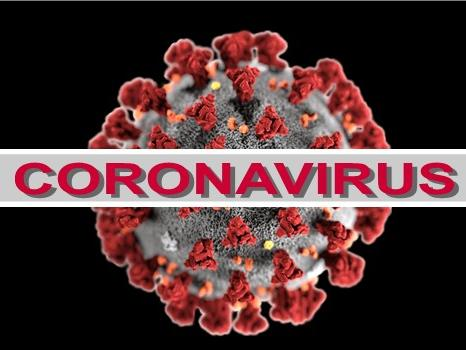

# **COVID-19:**

---



Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus.

Most people infected with the COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.

The best way to prevent and slow down transmission is be well informed about the COVID-19 virus, the disease it causes and how it spreads. Protect yourself and others from infection by washing your hands or using an alcohol based rub frequently and not touching your face.

The COVID-19 virus spreads primarily through droplets of saliva or discharge from the nose when an infected person coughs or sneezes, so it’s important that you also practice respiratory etiquette (for example, by coughing into a flexed elbow).

At this time, there are no specific vaccines or treatments for COVID-19. However, there are many ongoing clinical trials evaluating potential treatments. WHO will continue to provide updated information as soon as clinical findings become available.

# ***Introduction:***

---



A team of radiologists from New Orleans studied the usefulness of Chest Radiographs for diagnosing COVID-19 compared to the reverse-transcription polymerase chain reaction (RT-PCR) and found out they could aid rapid diagnosis, especially in areas with limited testing facilities.

Another study found out that the radiographs of different viral cases of pneumonia are comparative, and they overlap with other infectious and inflammatory lung diseases, making it hard for radiologists to recognize COVID‐19 from other viral pneumonia cases.

This project aims to make the former study a reality while dealing with the intricacies in the latter, with the help of Deep Learning.

[Kaggle DataSet](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database):

The database consists of 3616-COVID-19 positive along with 10,192-Normal, 6012- Lung Opacity (Non-COVID lung infection), and 1345-Viral Pneumonia images.





1.   Lets Install Kaggle 
2.   And Fork that dataset

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"garlapatipavankumar","key":"f76a5a59a7bd1e586a7cb7e6506925ed"}'}

In [3]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!ls

 99% 735M/745M [00:07<00:00, 70.6MB/s]
100% 745M/745M [00:07<00:00, 104MB/s] 
covid19-radiography-database.zip  kaggle.json  sample_data


In [5]:
%%capture
!unzip covid19-radiography-database.zip

In [6]:
import torch 
import torch.nn as nn
import torch.optim as optim  
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
) 
# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
import time
import copy
import cv2
from tqdm import tqdm


In [7]:

import random

from distutils.version import LooseVersion as Version
from itertools import product


def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    if torch.__version__ <= Version("1.7"):
        torch.set_deterministic(True)
    else:
        torch.use_deterministic_algorithms(True)


def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
        
    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

def cal_pre_rec(mat):
    labels = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    total_predicted = mat.sum(axis = 1)
    total_gold = mat.sum(axis = 0)
    
    for label in range(4):
        prec = mat[label, label] / total_predicted[label] * 100
        rec = mat[label, label] / total_gold[label] * 100
        f1 = 2 * prec * rec / (prec + rec) 
       

        print(labels[label], end = ' ')
        print(f'=> Precision: {round(prec, 2)}%, Recall: {round(rec, 2)}%, F1: {round(f1, 2)}%')
        print('-'*17)

In [8]:
import time
import torch


def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer,
                device, logging_interval=50,
                scheduler=None,
                scheduler_on='valid_acc'):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')

        if scheduler is not None:

            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list

In [9]:

import matplotlib.pyplot as plt



def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_training_loss.pdf')
        plt.savefig(image_path)


def plot_accuracy(train_acc_list, valid_acc_list, results_dir):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(
            results_dir, 'plot_acc_training_validation.pdf')
        plt.savefig(image_path)


def show_examples(model, data_loader, unnormalizer=None, class_dict=None):
    
        
    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            features = features
            targets = targets
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)
        break

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (8,5),#####
                             sharex=True, sharey=True)
    
    if unnormalizer is not None:
        for idx in range(features.shape[0]):
            features[idx] = unnormalizer(features[idx])
    nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))
    
    if nhwc_img.shape[-1] == 1:
        nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhw_img[idx], cmap='binary')
            if class_dict is not None:
                ax.title.set_text(f'R: {class_dict[predictions[idx].item()]}'
                                  f'\nP: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'R: {predictions[idx]} | P: {targets[idx]}')
            ax.axison = False

    else:

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhwc_img[idx])
            if class_dict is not None:
                ax.set_title(f'R: {class_dict[predictions[idx].item()]}\nP: {class_dict[targets[idx].item()]}')
                
            else:
                ax.set_title(f'R: {predictions[idx]} \nP: {targets[idx]}')
            ax.axison = False
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

In [10]:
import torch
from torch.utils.data import sampler
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms


class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Parameters:
        ------------
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        
        Returns:
        ------------
        Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


def get_dataloaders_mnist(batch_size, num_workers=0,
                          validation_fraction=None,
                          train_transforms=None,
                          test_transforms=None):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=train_transforms,
                                   download=True)

    valid_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=test_transforms)

    test_dataset = datasets.MNIST(root='data',
                                  train=False,
                                  transform=test_transforms)

    if validation_fraction is not None:
        num = int(validation_fraction * 60000)
        train_indices = torch.arange(0, 60000 - num)
        valid_indices = torch.arange(60000 - num, 60000)

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(valid_indices)

        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  sampler=valid_sampler)

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  sampler=train_sampler)

    else:
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  shuffle=True)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    if validation_fraction is None:
        return train_loader, test_loader
    else:
        return train_loader, valid_loader, test_loader


def get_dataloaders_cifar10(batch_size, num_workers=0,
                            validation_fraction=None,
                            train_transforms=None,
                            test_transforms=None):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.CIFAR10(root='data',
                                     train=True,
                                     transform=train_transforms,
                                     download=True)

    valid_dataset = datasets.CIFAR10(root='data',
                                     train=True,
                                     transform=test_transforms)

    test_dataset = datasets.CIFAR10(root='data',
                                    train=False,
                                    transform=test_transforms)

    if validation_fraction is not None:
        num = int(validation_fraction * 50000)
        train_indices = torch.arange(0, 50000 - num)
        valid_indices = torch.arange(50000 - num, 50000)

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(valid_indices)

        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  sampler=valid_sampler)

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  sampler=train_sampler)

    else:
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  shuffle=True)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    if validation_fraction is None:
        return train_loader, test_loader
    else:
        return train_loader, valid_loader, test_loader

In [21]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
)

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
# from PIL import Image
import time

warnings.filterwarnings("ignore")


# dataset_path = '.\\Combined_data' ### change this

def train_val_dataset(dataset):
    np.random.seed(1)
    num = np.arange(len(dataset))
    np.random.shuffle(num)

    train_idx, test_idx, val_idx = np.split(
        num, [int(.8*len(dataset)), int(.9*len(dataset))])  # len(dataset) didn't work -> 21165

    return train_idx, test_idx, val_idx


def split_train_test_loaders(dataset_path='/content/COVID-19_Radiography_Dataset', batch_size=64):
    np.random.seed(1)

    mean = [0.4363, 0.4328, 0.3291]
    std = [0.2129, 0.2075, 0.2038]
    
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])

    # train - test - validation split
    test_dataset = ImageFolder(dataset_path, transform=test_transforms)
    train_dataset = ImageFolder(dataset_path, transform=train_transforms)
    train_idx, test_idx, val_idx = train_val_dataset(test_dataset)

    test_data = Subset(test_dataset, test_idx)
    train_data = Subset(train_dataset, train_idx)
    val_data = Subset(train_dataset, val_idx)

    # loading data
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    return (train_data, val_data, test_data), train_loader, valid_loader, test_loader


def convert_lab(lab):
    label_dc = {0: 'COVID', 1: 'Lung_Opacity',
                2: 'Normal', 3: 'Viral Pneumonia'}
    return [label_dc[int(i)] for i in list(lab)]


def show_img(dataset_path='/content/COVID-19_Radiography_Dataset', train=False):
    mean = [0.4363, 0.4328, 0.3291]
    std = [0.2129, 0.2075, 0.2038]
    
    if train:
        train_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
        ])
        data = ImageFolder(dataset_path, transform=train_transforms)
    else:
        data_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        data = ImageFolder(dataset_path, transform=data_transform)

    loader = DataLoader(data, 4, shuffle=True)

    batch = next(iter(loader))
    img, lab = batch

    labels = convert_lab(lab)
    fig, axes = plt.subplots(1, 4, figsize=(20, 20))

    for ind, image in enumerate(img):
        axes[ind].imshow(image.permute(1, 2, 0))
        axes[ind].set_title(labels[ind])

    # fig.savefig('display_images.jpg')


def show_img_orig(data):
    loader = DataLoader(data, 4, shuffle=True)

    batch = next(iter(loader))
    img, lab = batch

    grid = torchvision.utils.make_grid(img, nrow=4)
    plt.figure(figsize=(11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))

    print(f'actual labels: {convert_lab(lab)}')
    print(f'numerical labels: {lab}')

In [22]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io
import cv2
import numpy as np

class LungXrayDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(os.path.join(self.root_dir, self.annotations.iloc[index, 5]), self.annotations.iloc[index, 0])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        
        y_label = torch.tensor(int(self.annotations.iloc[index, 4]))
        
        try:  
            if self.transform is not None:
                img = self.transform(image = img)['image']
        except:
            print('error here in cutom Dataset transforming')
            print(img.shape)
            print(self.annotations.iloc[index, 0])

    
        return (img, y_label)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
)

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
# from PIL import Image
import time
import copy
import cv2

from tqdm import tqdm
warnings.filterwarnings("ignore")



class FeatureExtractor():
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(
            self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0), -1)
            else:
                x = module(x)

        return target_activations, x


def preprocess_image(img):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.2255])
    preprocessing = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
    return preprocessing(img.copy()).unsqueeze(0)


def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(
            self.model, self.feature_module, target_layer_names)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        if self.cuda:
            input_img = input_img.cuda()

        features, output = self.extractor(input_img)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()

        one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_img.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


def deprocess_image(img):
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)


def store_gradcam_image(model, feature_module, target_layer_names, model_name, label, i):
    if not os.path.exists('gradcam_images'):
        os.makedirs('gradcam_images')
        
    img_path = os.path.join(
        f'/content/COVID-19_Radiography_Dataset//{label}', f'{label}-{i}.png')
    img = cv2.imread(img_path, 1)
    img = np.float32(img) / 255
    img = img.astype('float32')

    # Opencv loads as BGR:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_img = preprocess_image(img)

    grad_cam = GradCam(model=model, feature_module=feature_module,
                       target_layer_names= target_layer_names, use_cuda=torch.cuda.is_available())

    # If None, returns the map for the highest scoring category.
    # Otherwise, targets the requested category.
    target_category = None
    grayscale_cam = grad_cam(input_img, target_category)

    grayscale_cam = cv2.resize(grayscale_cam, (img.shape[1], img.shape[0]))
    cam = show_cam_on_image(img, grayscale_cam)
    cv2.imwrite(f"/content/COVID-19_Radiography_Dataset/gradcam_images//cam_{label}-{i}_{model_name}.jpg", cam)
    
    def display(model_name, label, i):
        fig, ax = plt.subplots(1, 2, figsize=(8, 8))
        img_path = os.path.join(
            f'/content/COVID-19_Radiography_Dataset//{label}', f'{label}-{i}.png')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cam = cv2.imread(f"/content/COVID-19_Radiography_Dataset/gradcam_images//cam_{label}-{i}_{model_name}.jpg")
        cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
        ax[0].imshow(img)
        ax[1].imshow(cam)
        ax[0].set_title(f'Original {label}-{model_name}')
        ax[1].set_title(f'Grad Cam {label}-{model_name}')
        fig.savefig(os.path.join('gradcam_images', f'Grad Cam {label}-{model_name}.jpg'))
        
    display(model_name, label, i)

    return None

In [14]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 128
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

Build Dataset:

Here the images are splitted and loaded into Train and Test sets.

In [15]:
dataset_path = '/content/COVID-19_Radiography_Dataset'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path, batch_size= BATCH_SIZE)

# **Pre-Visualization:**

---


Random Images are shown to check whether the images are loaded or not

**Here another set of random images are converted into rgb format from grayscale.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


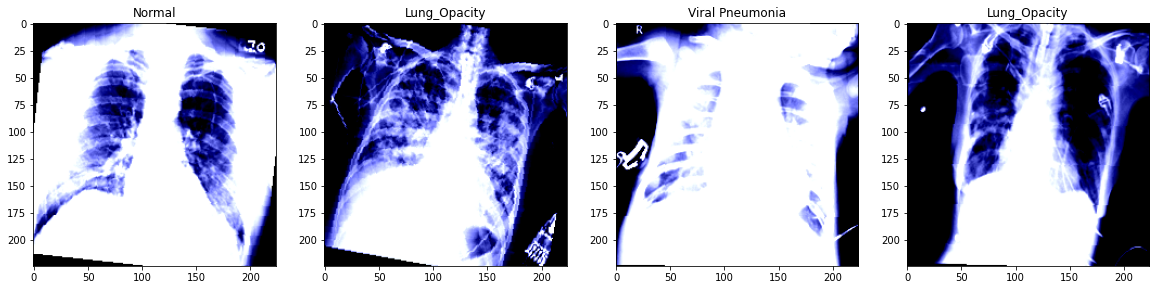

In [17]:
show_img(dataset_path= dataset_path, train= True)

# **Build Model**


---

**We are using Alexnet with slight modifications to attain beter performance.**


In [18]:
# show_img(dataset_path= dataset_path, train= True) 
model_ft = torchvision.models.alexnet(pretrained=True)
model_ft

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**Here we are modifying the**:


1.   **Classfier**
2.   **Last convolutional layers**

1.   **Capture those cn layers**





In [25]:
# load pretrained models
model_ft = torchvision.models.alexnet(pretrained=True)

# fine tune fully connected layer
for name, child in model_ft.named_children():
    if name in ['classifier']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

# fine tune last convolutional layer
for param in model_ft.features[10:].parameters():
    param.requires_grad = True

# change out_features of last linear layer
model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)


# Train
torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)
optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/020 | Batch 0000/0133 | Loss: 1.3449
Epoch: 001/020 | Batch 0050/0133 | Loss: 0.4892
Epoch: 001/020 | Batch 0100/0133 | Loss: 0.3903
Epoch: 001/020 | Train: 88.93% | Validation: 88.33%
Time elapsed: 3.25 min
Epoch: 002/020 | Batch 0000/0133 | Loss: 0.3600
Epoch: 002/020 | Batch 0050/0133 | Loss: 0.2255
Epoch: 002/020 | Batch 0100/0133 | Loss: 0.2958
Epoch: 002/020 | Train: 91.08% | Validation: 89.32%
Time elapsed: 6.41 min
Epoch: 003/020 | Batch 0000/0133 | Loss: 0.2058
Epoch: 003/020 | Batch 0050/0133 | Loss: 0.3038
Epoch: 003/020 | Batch 0100/0133 | Loss: 0.3380
Epoch: 003/020 | Train: 92.89% | Validation: 90.60%
Time elapsed: 9.58 min
Epoch: 004/020 | Batch 0000/0133 | Loss: 0.1741
Epoch: 004/020 | Batch 0050/0133 | Loss: 0.2517
Epoch: 004/020 | Batch 0100/0133 | Loss: 0.2234
Epoch: 004/020 | Train: 94.36% | Validation: 92.35%
Time elapsed: 12.70 min
Epoch: 005/020 | Batch 0000/0133 | Loss: 0.2050
Epoch: 005/020 | Batch 0050/0133 | Loss: 0.1646
Epoch: 005/020 | Batch 0100

**Then the model is saved into a .pth file**

In [26]:
torch.save(model_ft, os.path.join('/content/COVID-19_Radiography_Dataset/models', 'Alexnet.pth'))

# ***Performance Metrics:***

**Cross Entropy:**

Cross-entropy is a measure of the difference between two probability distributions for a given random variable or set of events. 

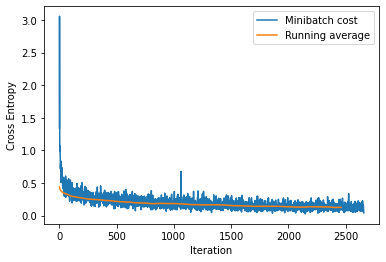

In [27]:
plt.plot(minibatch_loss_list_ft, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list_ft, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

***Plot Graph of Train & Valid:***

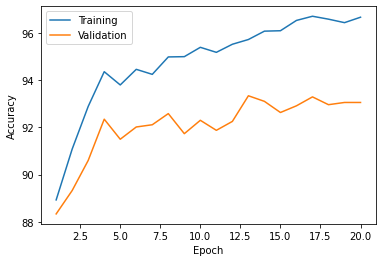

In [28]:

plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_ft, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_ft, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ***Prediction:***


1.   R:Real
2.   P:Prediction



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


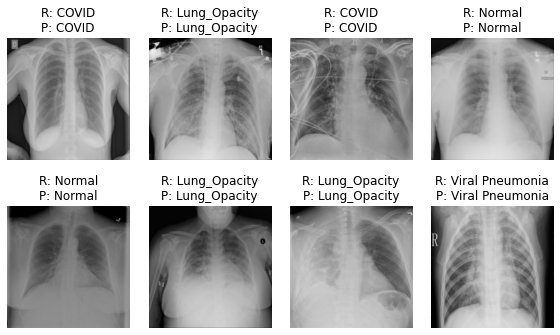

In [29]:
model_ft.cpu()
unnormalizer = UnNormalize((0.4363, 0.4328, 0.3291), (0.2129, 0.2075, 0.2038))
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

show_examples(model=model_ft, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

# ***Confusion Matrix:***

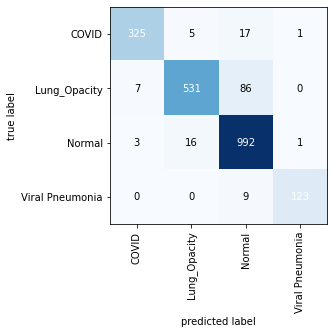

In [30]:
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
model_ft.to(DEVICE)

mat = compute_confusion_matrix(model=model_ft, data_loader=test_loader, device=DEVICE)
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

***Precision, Recall, F-1 Score:***

In [31]:
cal_pre_rec(mat)

COVID => Precision: 93.39%, Recall: 97.01%, F1: 95.17%
-----------------
Lung_Opacity => Precision: 85.1%, Recall: 96.2%, F1: 90.31%
-----------------
Normal => Precision: 98.02%, Recall: 89.86%, F1: 93.76%
-----------------
Viral Pneumonia => Precision: 93.18%, Recall: 98.4%, F1: 95.72%
-----------------


# ***Final Results:***

**Grad Cam:**

***Normal Image***

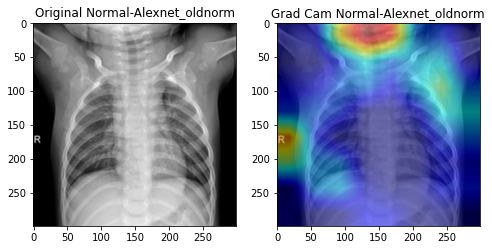

In [32]:
model_ft = torch.load(os.path.join('/content/COVID-19_Radiography_Dataset/models', 'Alexnet.pth'))
model_ft.to(DEVICE)

for param in model_ft.features.parameters():
    param.requires_grad = True

store_gradcam_image(model_ft,model_ft.features,['12'],'Alexnet_oldnorm','Normal',121)

***COVID***

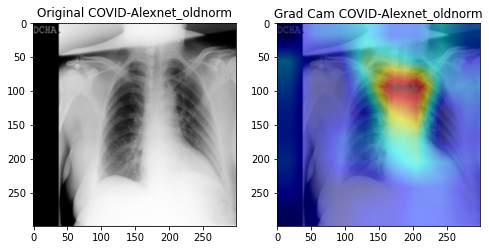

In [33]:
model_ft = torch.load(os.path.join('/content/COVID-19_Radiography_Dataset/models', 'Alexnet.pth'))
model_ft.to(DEVICE)

for param in model_ft.features.parameters():
    param.requires_grad = True

store_gradcam_image(model_ft,model_ft.features,['12'],'Alexnet_oldnorm','COVID',122)

***Lung Opacity***

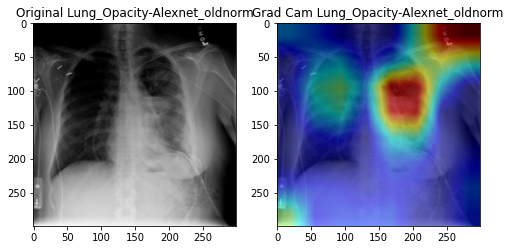

In [44]:
model_ft = torch.load(os.path.join('/content/COVID-19_Radiography_Dataset/models', 'Alexnet.pth'))
model_ft.to(DEVICE)

for param in model_ft.features.parameters():
    param.requires_grad = True

store_gradcam_image(model_ft,model_ft.features,['12'],'Alexnet_oldnorm','Lung_Opacity',1)

***Viral Pneumonia***

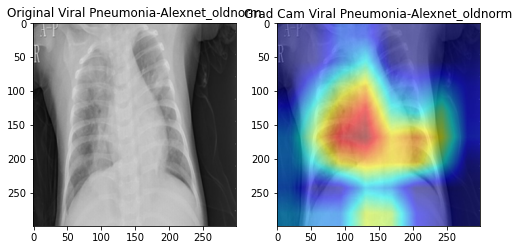

In [36]:
model_ft = torch.load(os.path.join('/content/COVID-19_Radiography_Dataset/models', 'Alexnet.pth'))
model_ft.to(DEVICE)

for param in model_ft.features.parameters():
    param.requires_grad = True

store_gradcam_image(model_ft,model_ft.features,['12'],'Alexnet_oldnorm','Viral Pneumonia',125)